In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import requests

# PULLING AND CLEANING THE DATA

In [2]:
dict1={0:pd.DataFrame(),1:pd.DataFrame,2:pd.DataFrame(),3:pd.DataFrame(),4:pd.DataFrame(),5:pd.DataFrame()}
email = 'youremail'
time_frame = 'Weekly'
from_date = '04/01/2000'
to_date = dt.datetime.now().strftime('%m/%d/%Y')

# COMMODITIES
name = ['gold','crude']
for x in range(len(name)):
    product_type = 'commodities'
    params = {
        "email": email,
        "type": "historical_data",
        "product": product_type,
        "from_date": from_date,
        "to_date": to_date,
        "time_frame": time_frame,
        "name": name[x],
    }
    
    response = requests.get("http://api.scraperlink.com/investpy/", params=params)
    data = response.json()
    dict1[x] = pd.DataFrame(data['data'])
    dict1[x] = dict1[x][['rowDateTimestamp','last_close', 'last_open', 'last_max', 'last_min']]
    dict1[x].columns = ['Date','Close','Open','Low','High']
    dict1[x]['Date'] = pd.to_datetime(dict1[x]['Date']).dt.date
    dict1[x] = dict1[x].sort_values(by = 'Date',ascending = True).reset_index(drop = True)
    for y in range(len(dict1[x].columns)-1):
        dict1[x][dict1[x].columns[y+1]] = dict1[x][dict1[x].columns[y+1]].replace(',','',regex = True)
        dict1[x][dict1[x].columns[y+1]] = dict1[x][dict1[x].columns[y+1]].astype(float)
    dict1[x]['Price'] = (dict1[x]['Close']*2 + dict1[x]['Open'] + dict1[x]['Low'] + dict1[x]['High'])/5
    dict1[x].drop(['Close','Open','High','Low'], axis = 1, inplace = True)

# INDICES
name = ['usdollar','SPX']
for x in range(len(name)):
    product_type = 'indices'
    params = {
        "email": email,
        "type": "historical_data",
        "product": product_type,
        "from_date": from_date,
        "to_date": to_date,
        "time_frame": time_frame,
        "symbol": name[x],
    }

    response = requests.get("http://api.scraperlink.com/investpy/", params=params)
    data = response.json()
    dict1[x+2] = pd.DataFrame(data['data'])
    dict1[x+2] = dict1[x+2][['rowDateTimestamp','last_close', 'last_open', 'last_max', 'last_min']]
    dict1[x+2].columns = ['Date','Close','Open','Low','High']
    dict1[x+2]['Date'] = pd.to_datetime(dict1[x+2]['Date']).dt.date
    dict1[x+2] = dict1[x+2].sort_values(by = 'Date',ascending = True).reset_index(drop = True)
    for y in range(len(dict1[x+2].columns)-1):
        dict1[x+2][dict1[x+2].columns[y+1]] = dict1[x+2][dict1[x+2].columns[y+1]].replace(',','',regex = True)
        dict1[x+2][dict1[x+2].columns[y+1]] = dict1[x+2][dict1[x+2].columns[y+1]].astype(float)
    dict1[x+2]['Price'] = (dict1[x+2]['Close']*2 + dict1[x+2]['Open'] + dict1[x+2]['Low'] + dict1[x+2]['High'])/5
    dict1[x+2].drop(['Close','Open','High','Low'], axis = 1, inplace = True)

# BONDS
name = ['U.S. 2Y','U.S. 10Y']
for x in range(len(name)):
    product_type = 'bonds'
    params = {
        "email": email,
        "type": "historical_data",
        "product": product_type,
        "from_date": from_date,
        "to_date": to_date,
        "time_frame": time_frame,
        "name": name[x],
        "country": 'united states'
    }
    
    response = requests.get("http://api.scraperlink.com/investpy/", params=params)
    dict1[x+4]  = pd.read_html(response.content)[0]
    dict1[x+4]  = dict1[x+4].drop('Change %', axis = 1)
    dict1[x+4]['Date'] = pd.to_datetime(dict1[x+4]['Date']).dt.date
    dict1[x+4] = dict1[x+4].sort_values(by = 'Date',ascending = True).reset_index(drop = True)
    for y in range(len(dict1[x+4].columns)-1):
        dict1[x+4][dict1[x+4].columns[y+1]] = dict1[x+4][dict1[x+4].columns[y+1]].replace(',','',regex = True)
        dict1[x+4][dict1[x+4].columns[y+1]] = dict1[x+4][dict1[x+4].columns[y+1]].astype(float)
    dict1[x+4]['Price'] = (dict1[x+4]['Price']*2 + dict1[x+4]['Open'] + dict1[x+4]['Low'] + dict1[x+4]['High'])/5
    dict1[x+4].drop(['Open','High','Low'], axis = 1, inplace = True)

# PREPARING THE DATA

In [27]:
# CHECKING IF ALL INSTRUMENTS HAVE EQUAL WEEKS
first = dict1[0]['Date'].tolist()
checker = []
for x in range(len(dict1)-1):
    checker.append(len(set(first)-set(dict1[x+1]['Date'].tolist())))
sum(checker) == 0 

False

In [29]:
cols = ['Gold','Crude','USDollar','S&P500','2Y Treasury Yield','10Y Treasury Yield']
for x in range(len(dict1)):
    dict1[x].columns = ['Date',cols[x]]
df0 = dict1[0]
for x in range(len(dict1)-1):
    df0 = df0.merge(dict1[x+1], how = 'inner', on = 'Date')

In [30]:
#df0.to_pickle("./AssetsData.pkl")

In [89]:
df = pd.read_pickle('AssetsData.pkl')
cols = ['Gold','Crude','USDollar','S&P500','2Y Treasury Yield','10Y Treasury Yield']

In [90]:
# 2000 Dot Com
# 5 Years After 2000 April 1
data_2000 = df[(df['Date']>pd.Timestamp('04/01/2000').date()) & (df['Date']<pd.Timestamp('04/01/2005').date())].reset_index(drop = True).copy()

# 2007 GFC
# 5 Years After 2007 October 1 
data_2007 = df[(df['Date']>pd.Timestamp('10/01/2007').date()) & (df['Date']<pd.Timestamp('10/01/2012').date())].reset_index(drop = True).copy()

# 2022 Downturn (Continued Bear?)
# 5 Years After 2022 January 1
data_2022 = df[(df['Date']>pd.Timestamp('01/01/2022').date()) & (df['Date']<pd.Timestamp('01/01/2027').date())].reset_index(drop = True).copy()


In [91]:
# Anchoring the very first week's mean price and calculating cumulative returns
for df in [data_2000, data_2007, data_2022]:
    df['Week'] = (((df['Date'] - df['Date'].shift(1))/7).dt.days).cumsum()
    df.iloc[0, 7] = 0
    df.drop('Date', axis=1, inplace=True)
    for col in cols:
        df[col] = ((df[col]/df[col].iloc[0])-1)
    df.set_index('Week', inplace=True)


# VISUALIZING THE DATA - 2000 Dotcom

<AxesSubplot:title={'center':'Dotcom Crash'}, xlabel='Week', ylabel='Cum. Returns'>

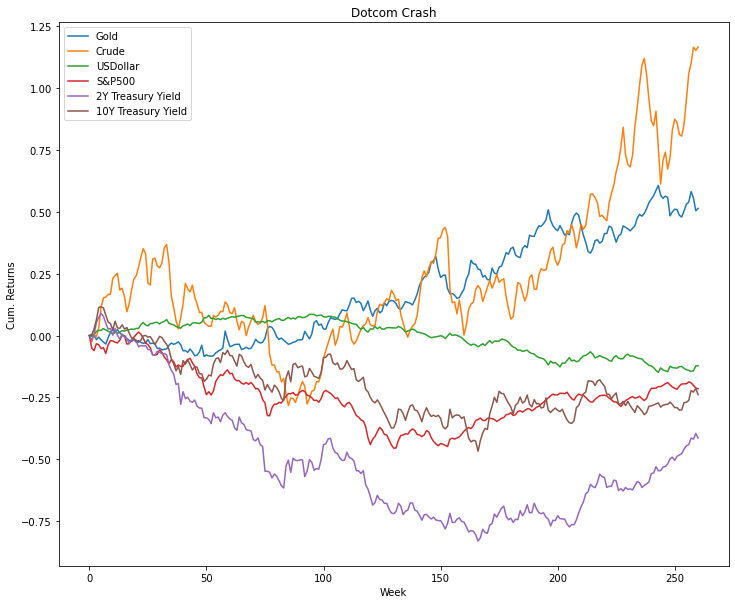

In [93]:
# 2000 dotcom
# GENERAL PLOT
fig, ax = plt.subplots(figsize = (12,10))
plt.title('Dotcom Crash')
plt.xlabel('Weeks')
plt.ylabel('Cum. Returns')
data_2000.plot(kind = 'line', ax = ax)

In [94]:
# PLOT WITH SLIDERS
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected = True)
cf.go_offline()
import chart_studio.plotly as py
data_2000.iplot(kind = 'line', yTitle = 'Cum. Returns', xTitle = 'Weeks', title = 'Dotcom Crash')

<IPython.core.display.Javascript object>


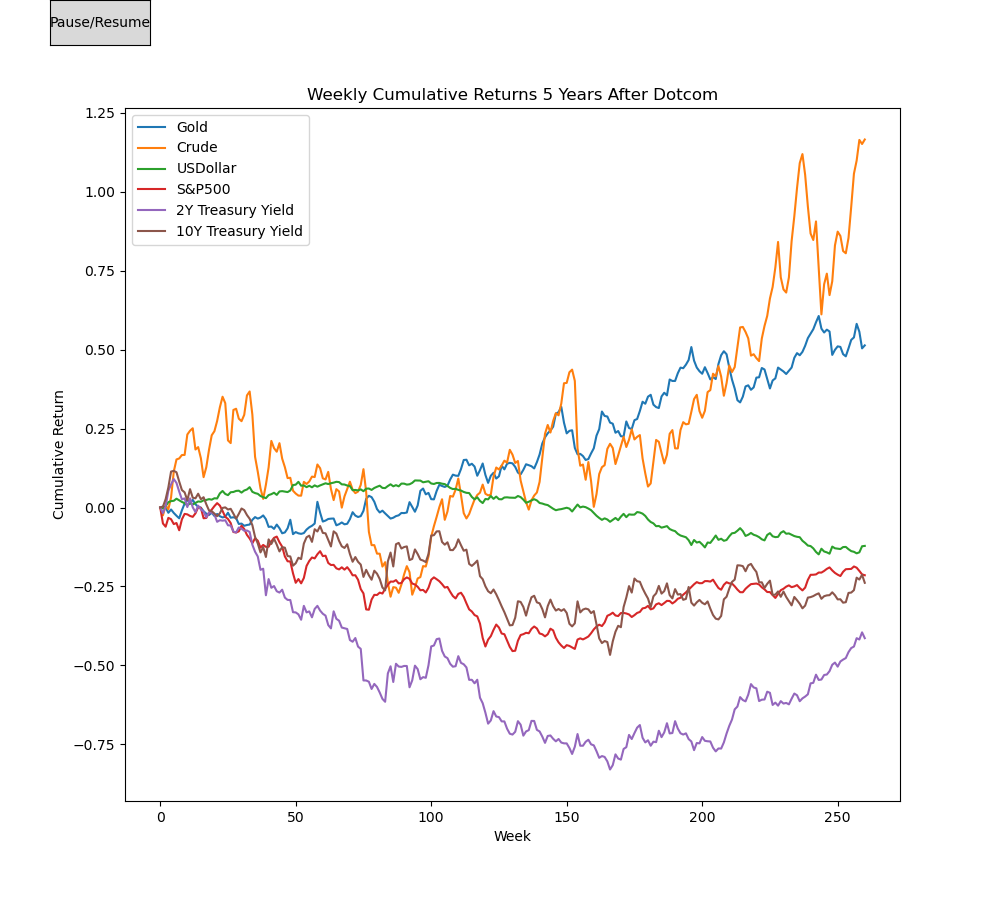

In [95]:
%matplotlib notebook
from matplotlib.widgets import Button
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 9))
plt.title ('Weekly Cumulative Returns 5 Years After Dotcom')
ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Return')
lines = []
for i in range(data_2000.shape[1]):
    line, = ax.plot([], [], label=data_2000.columns[i])
    lines.append(line)
ax.legend()

paused = False

def animate(i):
    global paused
    if not paused:
        for j in range(data_2000.shape[1]):
            lines[j].set_data(data_2000.iloc[:i+1, j].index, data_2000.iloc[:i+1, j])
        ax.relim()  
        ax.autoscale()  
    return lines

def on_pause_button_clicked(event):
    global paused
    paused = not paused

pause_button_ax = plt.axes([0.05, 0.95, 0.1, 0.05])
pause_button = Button(pause_button_ax, 'Pause/Resume')
pause_button.on_clicked(on_pause_button_clicked)

ani = FuncAnimation(fig, animate, frames=data_2000.shape[0], interval=100, repeat=False)
#ani.save('Assets 5 Years After Dotcom.gif', writer = 'pillow')
plt.show()

# VISUALIZING THE DATA - 2007 GFC

<AxesSubplot:title={'center':'GFC Crash'}, xlabel='Week', ylabel='Cum. Returns'>

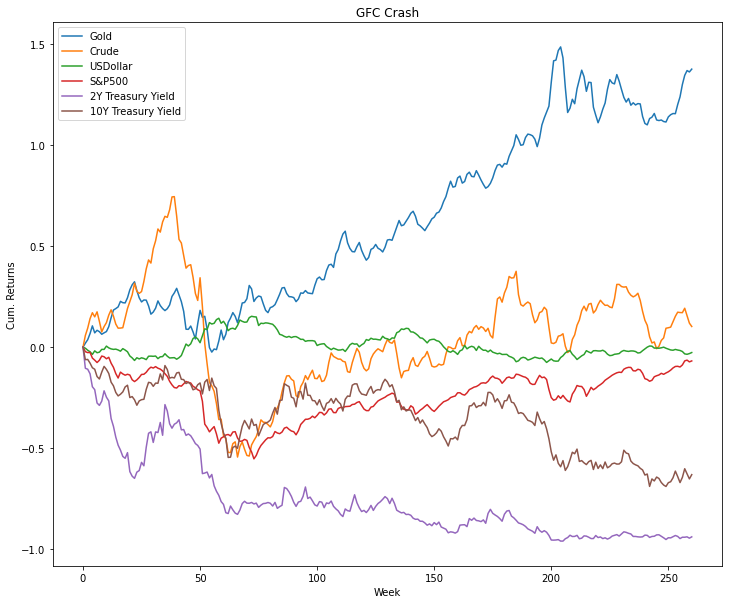

In [96]:
# 2007 GFC
# GENERAL PLOT
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,10))
plt.title('GFC Crash')
plt.xlabel('Weeks')
plt.ylabel('Cum. Returns')
data_2007.plot(kind = 'line', ax = ax)

In [97]:
# PLOT WITH SLIDERS
data_2007.iplot(kind = 'line', yTitle = 'Cum. Returns', xTitle = 'Weeks', title = 'GFC Crash')

<IPython.core.display.Javascript object>


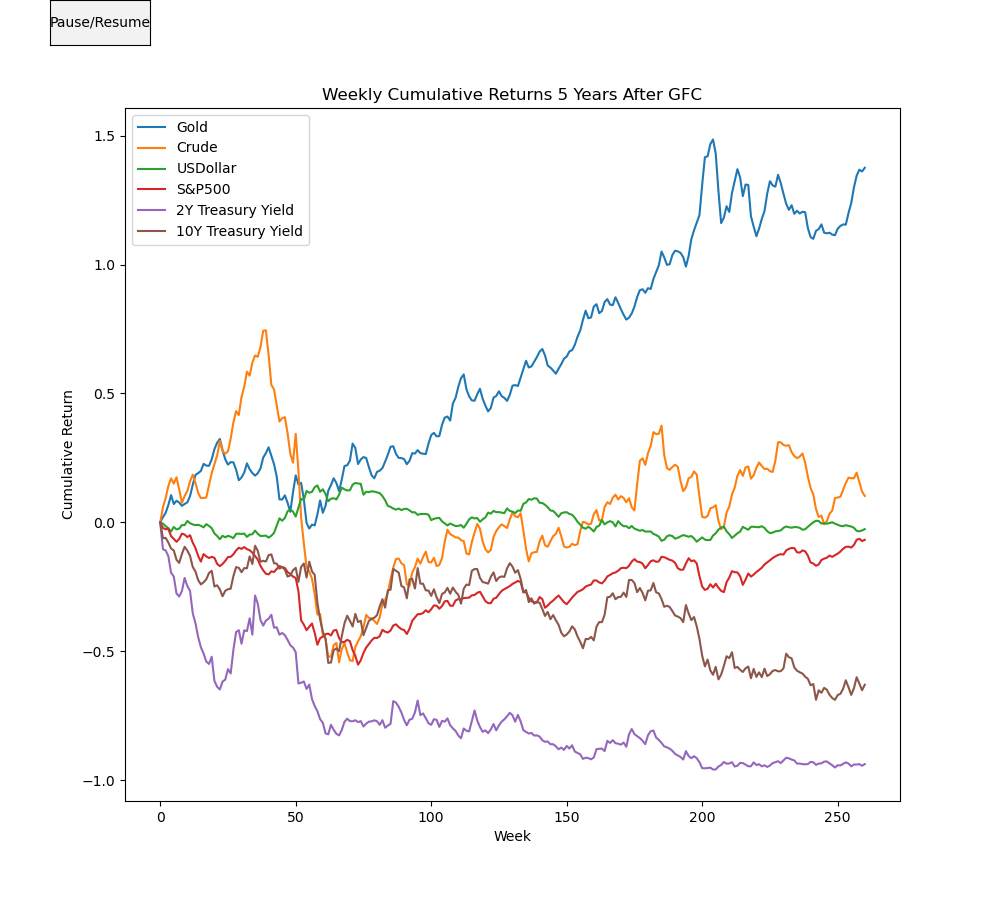

In [98]:
%matplotlib notebook
from matplotlib.widgets import Button
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 9))
plt.title ('Weekly Cumulative Returns 5 Years After GFC')
ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Return')
lines = []
for i in range(data_2007.shape[1]):
    line, = ax.plot([], [], label=data_2007.columns[i])
    lines.append(line)
ax.legend()

paused = False

def animate(i):
    global paused
    if not paused:
        for j in range(data_2007.shape[1]):
            lines[j].set_data(data_2007.iloc[:i+1, j].index, data_2007.iloc[:i+1, j])
        ax.relim()  
        ax.autoscale()  
    return lines

def on_pause_button_clicked(event):
    global paused
    paused = not paused

pause_button_ax = plt.axes([0.05, 0.95, 0.1, 0.05])
pause_button = Button(pause_button_ax, 'Pause/Resume')
pause_button.on_clicked(on_pause_button_clicked)

ani = FuncAnimation(fig, animate, frames=data_2007.shape[0], interval=100, repeat=False)
#ani.save('Assets 5 Years After GFC.gif', writer = 'pillow')
plt.show()


# VISUALIZING THE DATA - 2022 Now

<AxesSubplot:title={'center':'2022 Crash'}, xlabel='Week', ylabel='Cum. Returns'>

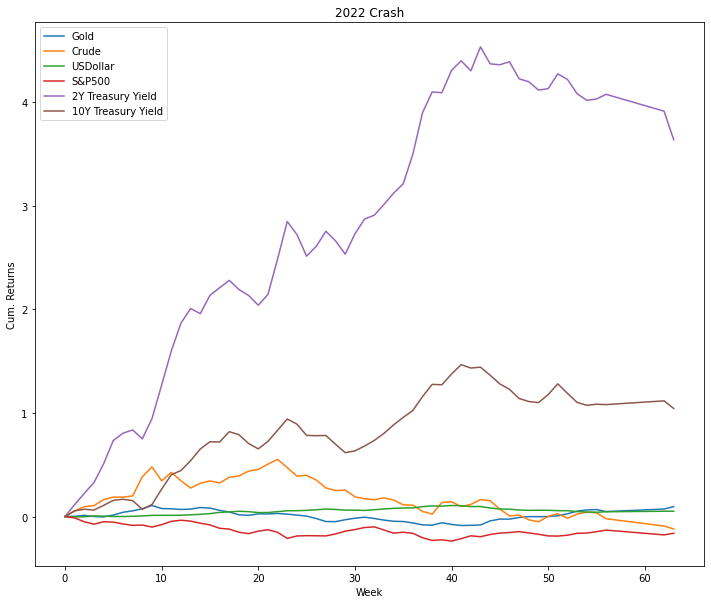

In [99]:
# 2022 Now
# GENERAL PLOT
%matplotlib inline
fig, ax = plt.subplots(figsize = (12,10))
plt.title('2022 Crash')
plt.xlabel('Weeks')
plt.ylabel('Cum. Returns')
data_2022.plot(kind = 'line', ax = ax)

In [100]:
# PLOT WITH SLIDERS
data_2022.iplot(kind = 'line', yTitle = 'Cum. Returns', xTitle = 'Weeks', title = '2022 Crash')

<IPython.core.display.Javascript object>


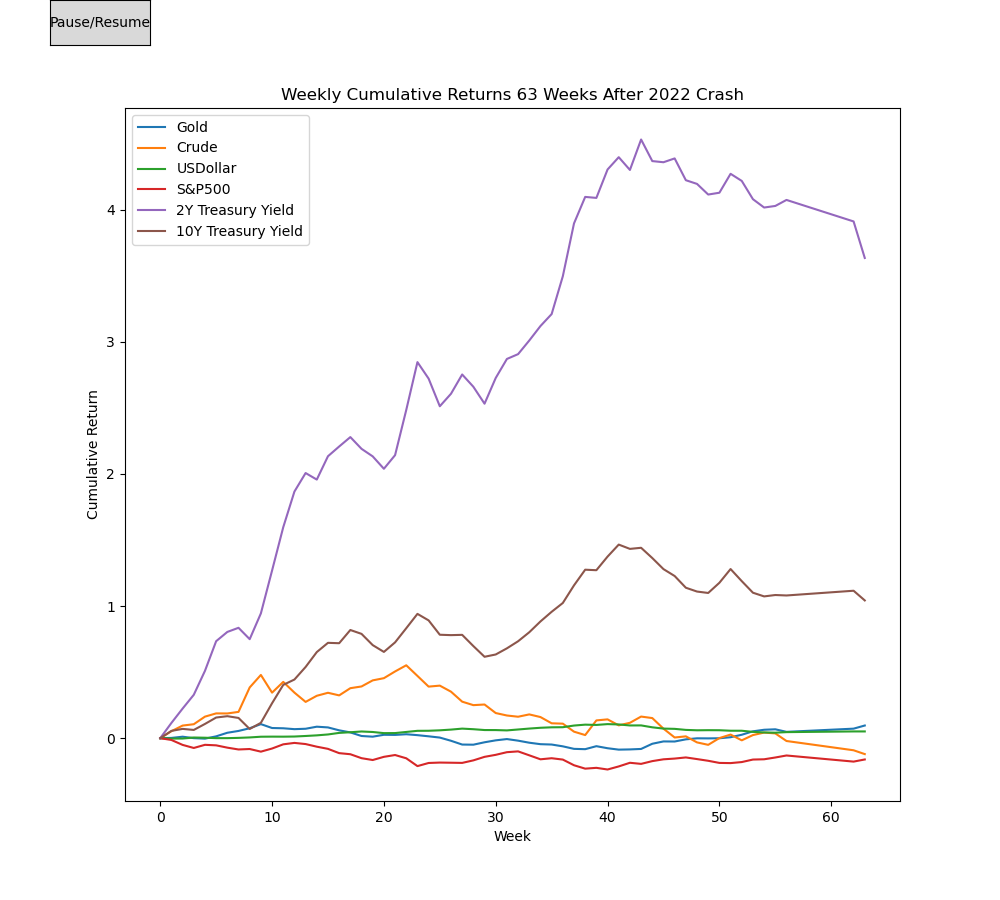

In [111]:
%matplotlib notebook
from matplotlib.widgets import Button
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 9))
plt.title ('Weekly Cumulative Returns '+ str(int(data_2022.index[-1]))+ ' Weeks After 2022 Crash')
ax.set_xlabel('Week')
ax.set_ylabel('Cumulative Return')
lines = []
for i in range(data_2022.shape[1]):
    line, = ax.plot([], [], label=data_2022.columns[i])
    lines.append(line)
ax.legend()

paused = False

def animate(i):
    global paused
    if not paused:
        for j in range(data_2022.shape[1]):
            lines[j].set_data(data_2022.iloc[:i+1, j].index, data_2022.iloc[:i+1, j])
        ax.relim()  
        ax.autoscale()  
    return lines

def on_pause_button_clicked(event):
    global paused
    paused = not paused

pause_button_ax = plt.axes([0.05, 0.95, 0.1, 0.05])
pause_button = Button(pause_button_ax, 'Pause/Resume')
pause_button.on_clicked(on_pause_button_clicked)

ani = FuncAnimation(fig, animate, frames=data_2022.shape[0], interval=400, repeat=False)
#ani.save('Assets '+ str(int(data_2022.index[-1]))+ ' Weeks After 2022 Crash.gif', writer = 'pillow')
plt.show()
